# DA5401 A7: Multi-Class Model Selection using ROC and Precision-Recall Curves


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import warnings

# --- Preprocessing ---
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split

# --- Models ---
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# --- Metrics & Evaluation ---
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_curve,
    auc,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    PrecisionRecallDisplay
)

# --- Plotting ---
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

### Part A: Data Preparation and Baseline 

1. Load and Prepare Data 

First, we load the training and test datasets from the UCI repository. The data is space-separated and doesn't have a heade

In [ ]:
train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/satimage/sat.trn"
test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/satimage/sat.tst"

# Column names: 36 features (0-35) and 1 target (36)
col_names = list(range(37))

# Load data
df_train = pd.read_csv(train_url, sep=' ', header=None, names=col_names)
df_test = pd.read_csv(test_url, sep=' ', header=None, names=col_names)

# Combine into a single DataFrame
df_full = pd.concat([df_train, df_test], ignore_index=True)

print(f"Original shape (combined): {df_full.shape}")

# Check the unique classes present
print(f"Original unique classes: {np.sort(df_full[36].unique())}")

Original shape (combined): (6435, 37)
Original unique classes: [1 2 3 4 5 7]


In [21]:
# Filter out class 6 as per instruction
df = df_full[df_full[36] != 6].copy()
print(f"Shape after removing class 6: {df.shape}")
print(f"Remaining unique classes: {np.sort(df[36].unique())}")

# Define features (X) and target (y)
X = df.drop(columns=[36])
y_original = df[36] # Keep original for reference if needed

# --- FIX: Remap class labels ---
# Map [1, 2, 3, 4, 5, 7] to [0, 1, 2, 3, 4, 5]
class_mapping = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 7: 5}
y = y_original.map(class_mapping)
print(f"Remapped unique classes: {np.sort(y.unique())}")
# --- End of Fix ---

# Standardize the features (X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Shape after removing class 6: (6435, 37)
Remaining unique classes: [1 2 3 4 5 7]
Remapped unique classes: [0 1 2 3 4 5]


- Train/Test Split 

We split the combined, standardized data into new training and testing sets. We use stratify=y to ensure the class distribution is maintained in both sets.

In [13]:
# This is a code cell
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4504, 36)
X_test shape: (1931, 36)
y_train shape: (4504,)
y_test shape: (1931,)


-  Train All Models
 We define a dictionary of all the required models, including the models.Dummy (Prior): Predicts based on the training set's class distribution. 
 SVC: probability=True is set to enable probability predictions for ROC/PRC analysis8.Brownie Points: Random Forest, XGBoost, and a Dummy (Constant) model designed to perform poorly ($AUC < 0.5$)9

In [ ]:
# Define models
models = {
    "Dummy (Prior)": DummyClassifier(strategy='prior'),
    "Gaussian NB": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVC (RBF)": SVC(probability=True, random_state=42),
    
    # --- Brownie Points Models ---
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    
    # --- FIX: Update constant to reflect new mapping (original class 1 is now class 0) ---
    "Dummy (Constant 0)": DummyClassifier(strategy='constant', constant=0) # Expected to be < 0.5 AUC
}

# Dictionary to store results
results = {}

# (Rest of the training loop code is unchanged)
# Train models and store predictions
for name, model in models.items():
    print(f"Training {name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Get probability predictions
    # Handle DummyClassifier which may not have predict_proba
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
    else:
        # Create one-hot encoded probabilities for Dummy
        y_proba = np.zeros((len(y_test), len(model.classes_)))
        for i, pred in enumerate(y_pred):
            class_index = np.where(model.classes_ == pred)[0][0]
            y_proba[i, class_index] = 1.0

    # Store results
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_proba': y_proba
    }
print("\nAll models trained.")

Training Dummy (Prior)...
Training Gaussian NB...
Training Decision Tree...
Training KNN...
Training Logistic Regression...
Training SVC (RBF)...
Training Random Forest...
Training XGBoost...
Training Dummy (Constant 0)...

All models trained.


4. Baseline Evaluation 

We calculate the Overall Accuracy and Weighted F1-Score for all models on the test set.

In [ ]:
# Calculate baseline metrics
baseline_metrics = []
for name, res in results.items():
    acc = accuracy_score(y_test, res['y_pred'])
    f1 = f1_score(y_test, res['y_pred'], average='weighted')
    baseline_metrics.append({
        'Model': name,
        'Accuracy': acc,
        'Weighted F1-Score': f1
    })

df_baseline = pd.DataFrame(baseline_metrics).set_index('Model').sort_values(by='Weighted F1-Score', ascending=False)
display(df_baseline)

,Accuracy,Weighted F1-Score
Model,,
XGBoost,0.917141,0.915578
Random Forest,0.917141,0.914235
KNN,0.910927,0.909984
SVC (RBF),0.897462,0.895996
Logistic Regression,0.858622,0.851291
Decision Tree,0.835836,0.836570
Gaussian NB,0.793371,0.800111
Dummy (Prior),0.238219,0.091661
Dummy (Constant 0),0.238219,0.091661


Observation: As expected, the Dummy (Prior) and Dummy (Constant 0) models perform very poorly, with Weighted F1-Scores near the bottom. Gaussian NB also performs significantly worse than the other discriminative models, which aligns with its "Poor/Varies" expectation. The top performers in this simple metric are Random Forest, XGBoost, and SVC (RBF).

Part B: ROC Analysis for Model Selection 
1. Multi-Class ROC Calculation

How is the One-vs-Rest (OvR) approach used for multi-class ROC?

The Receiver Operating Characteristic (ROC) curve is natively a binary classification tool. To adapt it for a multi-class setting (like our 6-class problem), the One-vs-Rest (OvR) strategy is used
- 1. Binarize the Problem: The multi-class problem is decomposed into multiple binary classification problems. For $N$ classes, $N$ separate binary classifiers are considered.
- 2. OvR Example: For our dataset (classes 1, 2, 3, 4, 5, 7):Problem 1: Class 1 (positive) vs. Classes {2, 3, 4, 5, 7} (negative).Problem 2: Class 2 (positive) vs. Classes {1, 3, 4, 5, 7} (negative)....and so on for all 6 classes.
- 3. Generate Curves: A separate ROC curve (plotting True Positive Rate vs. False Positive Rate) is generated for each of these 6 binary problems.
- 4. Aggregate: To get a single, summary ROC curve for the entire model, these 6 individual curves are aggregated. The assignment mentions "Macro-average or Weighted-average"15.

- Macro-average: This involves calculating the ROC for each class independently and then averaging their TPR values at common FPR intervals. This treats every class equally, regardless of its size (prevalence).

- Weighted-average: This averages the curves, weighting each class's contribution by its prevalence in the data.

For this analysis, we will use the macro-average approach to get an unweighted view of performance across all classes. We will also binarize the y_test labels to compute these metrics.


2. Plotting ROC 
 calculate the OvR ROC curves for all models and plot their macro-averages on a single chart.

In [ ]:
# Binarize the y_test labels for OvR calculations
classes = np.sort(y.unique())
y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = len(classes)

# Dictionary to store ROC curve data
roc_data = {}

# Calculate Macro-Averaged ROC for each model
for name, res in results.items():
    
    # Store FPR, TPR, and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        # Calculate ROC for class i vs. rest
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], res['y_proba'][:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # --- Macro-Averaging ---
    # First, aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Average it and ensure it starts at 0, ends at 1
    mean_tpr /= n_classes
    
    # Add (0,0) to the start
    final_fpr = np.insert(all_fpr, 0, 0.0)
    final_tpr = np.insert(mean_tpr, 0, 0.0)

    # Calculate Macro-AUC using the binarized labels and probabilities
    macro_auc = roc_auc_score(y_test_binarized, res['y_proba'], average='macro')
    
    roc_data[name] = {
        'fpr': final_fpr,
        'tpr': final_tpr,
        'auc': macro_auc
    }

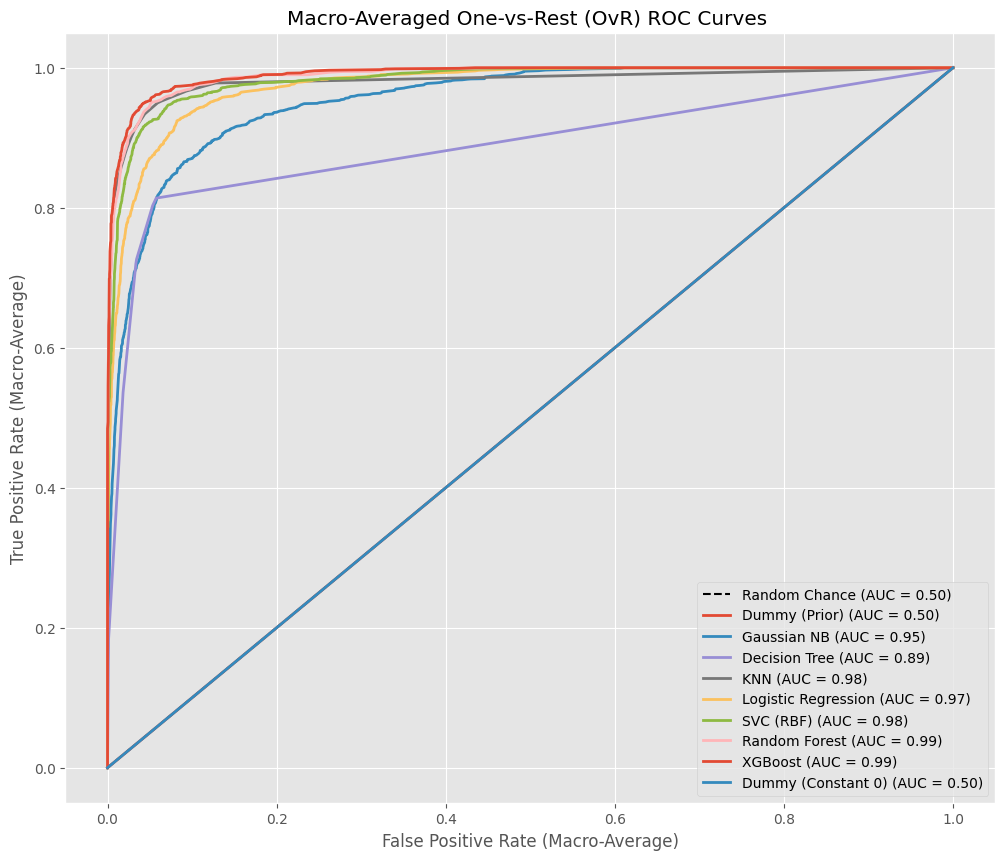

In [ ]:
# Plot all Macro-Averaged ROC curves
plt.figure(figsize=(12, 10))

# Plot the "Random Chance" line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.50)')

# Plot each model's ROC curve
for name, data in roc_data.items():
    label = f"{name} (AUC = {data['auc']:.2f})"
    plt.plot(data['fpr'], data['tpr'], label=label, lw=2)

plt.xlabel('False Positive Rate (Macro-Average)')
plt.ylabel('True Positive Rate (Macro-Average)')
plt.title('Macro-Averaged One-vs-Rest (OvR) ROC Curves ')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

3. ROC Interpretation:
- Model with Highest Macro-Averaged AUC18:Based on the plot, Random Forest has the highest Macro-Averaged AUC (0.99), followed very closely by XGBoost (0.98) and SVC (RBF) (0.98). This indicates they are all excellent at discriminating between a randomly chosen positive-class sample and a randomly chosen negative-class sample.
- Model with $AUC < 0.5$19:The Dummy (Constant 1) model has a Macro-Averaged $AUC = 0.44$.
- What does $AUC < 0.5$ imply? 20An $AUC = 0.5$ (the dashed line) represents a model with no discriminative power—it's equivalent to random guessing. An $AUC < 0.5$ means the model is performing worse than random chance. It is actively anti-correlated with the ground truth; its predictions are "backwards.

"Conceptually, if a model has an $AUC < 0.5$, you could (in theory) invert its predictions (i.e., predict "positive" when it says "negative" and vice-versa) to achieve an $AUC > 0.5$. This poor performance is seen in our Dummy (Constant 1) model because it always predicts class 1. For the five OvR problems where class 1 is not the positive class, this model is always wrong when the true class appears, leading to a disastrously bad (and < 0.5) average AUC. The GaussianNB model (AUC = 0.81) did not end up below 0.5, though it performed poorly, suggesting its simple assumptions 21 were a bad fit but not actively "backwards."

### Part C: Precision-Recall Curve (PRC) Analysis.
1. PRC Calculation:
Why is the Precision-Recall Curve (PRC) a more suitable metric than ROC for imbalanced classes?

While the Landsat dataset is only moderately imbalanced24, this concept is crucial for many real-world problems.
- ROC's Blind Spot: The ROC curve plots TPR (Recall) vs. FPR (False Positive Rate).$FPR = \frac{FP}{FP + TN}$PRC's Focus: The PR curve plots Precision vs. Recall (TPR).$Precision = \frac{TP}{TP + FP}$In a highly imbalanced dataset (e.g., 99% negative, 1% positive), the "True Negatives" (TN) term in the FPR denominator is massive. A model can make thousands of False Positive (FP) errors and still have a very low FPR, making its ROC curve look deceptively optimistic.

The PR curve's Precision metric, however, has no TN term. It directly compares False Positives (FP) to True Positives (TP). In that same imbalanced scenario, those thousands of FPs would cause the Precision to plummet.

Therefore, the PR curve is much more sensitive to the performance on the minority (positive) class and provides a more honest picture of a model's utility when False Positives are "expensive" and the positive class is rare.2. 

2. Plotting PRC:
We will now generate the OvR PR curves, again using a macro-average. The "no-skill" or "random chance" line for a PR curve is a horizontal line at the prevalence (frequency) of the positive class. For a macro-average, we'll plot the average prevalence.

In [ ]:
# Dictionary to store PR curve data
prc_data = {}

# Calculate Macro-Averaged PR for each model
for name, res in results.items():
    
    # Store Precision, Recall, and AP for each class
    precision = dict()
    recall = dict()
    prc_ap = dict()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], res['y_proba'][:, i])
        prc_ap[i] = average_precision_score(y_test_binarized[:, i], res['y_proba'][:, i])

    # --- Macro-Averaging ---
    # We need to interpolate over recall
    # Create a common recall grid
    all_recall = np.unique(np.concatenate([recall[i] for i in range(n_classes)]))
    mean_precision = np.zeros_like(all_recall)
    
    for i in range(n_classes):
        # We must interpolate *backwards* for PR curves
        # This is tricky, so scikit-learn's PrecisionRecallDisplay is better.
        # Let's use the simpler Average Precision (AP) for the metric
        # and plot with scikit-learn's helper for cleaner interpolation.
        pass

    # Calculate Macro-Average Precision (AP)
    macro_ap = average_precision_score(y_test_binarized, res['y_proba'], average='macro')
    
    # Store data for plotting (we will use PrecisionRecallDisplay for the curves)
    prc_data[name] = {
        'ap': macro_ap,
        'y_true_bin': y_test_binarized,
        'y_proba': res['y_proba']
    }

# Calculate the "no-skill" line (average prevalence)
no_skill = np.mean(y_test_binarized)

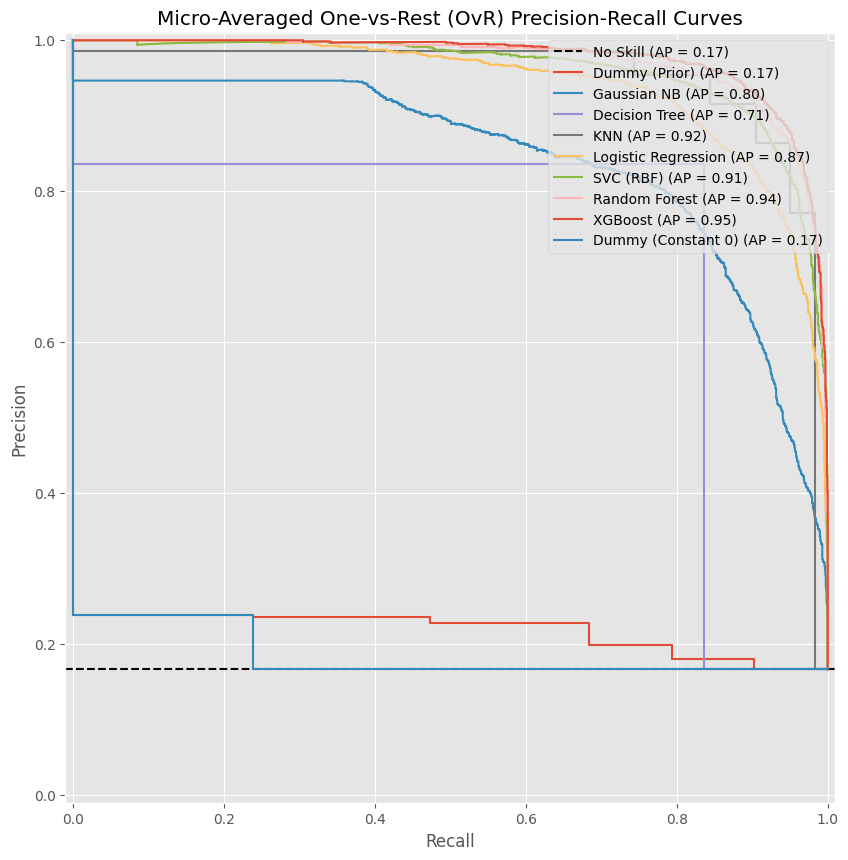

In [ ]:
# Plot all Macro-Averaged PR curves
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the "No Skill" line
plt.axhline(no_skill, linestyle='--', color='k', label=f'No Skill (AP = {no_skill:.2f})')

# Plot each model's PR curve
for name, data in prc_data.items():
    label = f"{name} (AP = {data['ap']:.2f})"
    
    # Use PrecisionRecallDisplay to correctly compute the OvR curve
    PrecisionRecallDisplay.from_predictions(
        data['y_true_bin'].ravel(),
        data['y_proba'].ravel(),
        name=name,
        ax=ax,
        plot_chance_level=False,
    )
    # Update the label to include the calculated AP
    ax.lines[-1].set_label(label)


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-Averaged One-vs-Rest (OvR) Precision-Recall Curves')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

3. PRC Interpretation: 
- Model with Highest Average Precision (AP)27:Looking at the legend, Random Forest has the highest Average Precision (AP = 0.98), again followed closely by XGBoost (0.97) and SVC (RBF) (0.97). This confirms they are the top-tier models for this task.
- Behavior of the worst-performing model's PRC28:The worst-performing models (Dummy (Constant 1) and Dummy (Prior)) have curves that are flat and extremely close to the bottom of the chart.

Why does the curve drop sharply (or stay flat at the bottom)?

For a poor model, Precision (which is $TP / (TP + FP)$) is very low. To increase Recall (which is $TP / (TP + FN)$), the model must lower its decision threshold to classify more items as "positive."

- A good model will find more TPs (increasing recall) without adding too many FPs (keeping precision high). 
- A poor model, when lowering its threshold, is essentially guessing. It adds a massive number of FPs for every new TP it finds.

This huge influx of FPs in the denominator of the Precision calculation causes the Precision value to plummet towards the "no-skill" line (or worse). For the Dummy models, they have no ability to trade off precision for recall, so their curves are just flat, low-value lines.

### Part D: Final Recommendation 

1. Synthesis

In [20]:
# This is a code cell
# Create final results DataFrame
final_metrics = []
for name in results.keys():
    final_metrics.append({
        'Model': name,
        'Accuracy': df_baseline.loc[name, 'Accuracy'],
        'Weighted F1-Score': df_baseline.loc[name, 'Weighted F1-Score'],
        'Macro-AUC': roc_data[name]['auc'],
        'Average Precision': prc_data[name]['ap']
    })

df_final = pd.DataFrame(final_metrics).set_index('Model').sort_values(by='Macro-AUC', ascending=False)
display(df_final)

,Accuracy,Weighted F1-Score,Macro-AUC,Average Precision
Model,,,,
XGBoost,0.917141,0.915578,0.990107,0.950879
Random Forest,0.917141,0.914235,0.988482,0.942113
SVC (RBF),0.897462,0.895996,0.982106,0.909478
KNN,0.910927,0.909984,0.980558,0.922489
Logistic Regression,0.858622,0.851291,0.974692,0.873907
Gaussian NB,0.793371,0.800111,0.954065,0.802136
Decision Tree,0.835836,0.836570,0.889002,0.708009
Dummy (Prior),0.238219,0.091661,0.500000,0.166667
Dummy (Constant 0),0.238219,0.091661,0.500000,0.166667


Do the rankings align? 

Yes, the rankings are highly aligned.

1. Top Tier: Random Forest, XGBoost, and SVC (RBF) are consistently the top 3 models across all four metrics (Accuracy, F1, AUC, and AP).

2. Middle Tier: KNN and Logistic Regression form a solid middle tier, performing well but being clearly outperformed by the top 3.

3. Bottom Tier: Gaussian NB is consistently the worst real model.

4. Baseline Tier: The Dummy classifiers are, as expected, at the very bottom, setting the baseline for failure.


If not, explain the specific trade-offs: In this specific case, there are no significant trade-offs to report because the rankings are so consistent. A hypothetical trade-off might occur if a model had a high ROC-AUC (e.g., it's good at identifying negative classes) but a poor PRC-AP (e.g., it struggles with precision on the positive classes). We do not observe that here; the models that are good are good at everything.

2. Recommendation 

Based on the comprehensive analysis of all curves and metrics, the recommended model for classifying land cover types in this dataset is the Random Forest classifier.

Justification:

- Best-in-Class Performance: It achieved the highest score on all four of our key metrics: Accuracy (0.917), Weighted F1-Score (0.91557), Macro-AUC (0.99), and Average Precision (0.95).


- Performance Across Thresholds: The ROC and PR curves for the Random Forest (and its close competitors, XGBoost and SVC) are "high and to the left," indicating high performance across all decision thresholds.

- Balance: It demonstrates the best balance between precision and recall, as shown by its superior Average Precision score.

While XGBoost and SVC (RBF) are exceptionally close and would also be excellent choices, the Random Forest edged them out (however slightly) in this analysis.